In [2]:
from __future__ import division, print_function

from functools import partial

import gpflow
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import signal, linalg

# Nice progress bars
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x: x

import safe_learning
import plotting
from utilities import InvertedPendulum

%matplotlib inline

# Open a new session (close old one if exists)
try:
    session.close()
except NameError:
    pass

session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())

# Define underlying dynamic system and costs/rewards
Define the dynamics of the true and false system


In [3]:
import sys
import os
import importlib
import numpy as np
import tensorflow as tf
from scipy import signal
from safe_learning import DeterministicFunction
from safe_learning import config
from safe_learning.utilities import concatenate_inputs
if sys.version_info.major == 2:
    import imp
    
# Corresponding dynamic systems
@safe_learning.utilities.with_scope('true_dynamics')
def true_dynamics(state_action, action=None):
    """Return future states of the car"""  
    if action is None:
        states, actions = tf.split(state_action, [2, 1], axis=1)
    else:
        states = state_action
        actions = action
    x0 = states[:, 0] + states[:, 1]
    x1 = states[:, 1] + 0.001 * actions[:, 0]
    
    return tf.stack((x0, x1), axis=1)

@safe_learning.utilities.with_scope('wrong_dynamics')
@concatenate_inputs(start=1)
def wrong_dynamics(state_action):
    """Return future states of the car"""    
    if action is None:
        states, actions = tf.split(state_action, [2, 1], axis=1)
    else:
        states = state_action
        actions = action
    states, actions = tf.split(state_action, [2, 1], axis=1)
    x0 = states[:, 0] + states[:, 1]
    x1 = states[:, 1] + 0.005 * actions[:, 0]
    
    return tf.stack((x0, x1), axis=1)


# LQR cost matrices
q = 1 * np.diag([1., 2.])
r = 1.2 * np.array([[1]], dtype=safe_learning.config.np_dtype)

# Quadratic (LQR) reward function
reward_function = safe_learning.QuadraticFunction(linalg.block_diag(-q, -r))

# Discount factor
gamma = .98
# terminal_reward = 1 - gamma
# @safe_learning.utilities.with_scope('reward_function')
# @concatenate_inputs(start=1)
# def reward_function(states, actions):
#     """Reward function for the mountain car"""
#     zeros = tf.zeros((states.shape[0], 1), tf.float64)
#     ones = tf.ones_like(zeros)
#     # Reward is zero except at terminal states
#     return tf.where(tf.greater(states[:, 0], 1), terminal_reward * ones, zeros)

# Set up a discretization for safety verification

In [4]:
# Set up a discretization for safety verification
state_limits = np.array([[-1.5, 1.5], [-.1, .1]])
safety_num_states = [50, 50]
policy_num_states = [20, 20]

safety_disc = safe_learning.GridWorld(state_limits, safety_num_states)
policy_disc = safe_learning.GridWorld(state_limits, policy_num_states)

# Discretization constant
tau = np.min(safety_disc.unit_maxes)

print('Grid size: {0}'.format(safety_disc.nindex))

Grid size: 2500


# Define the GP dynamics model

We use a combination of kernels to model the errors in the dynamics

In [5]:
A = np.array([[1, 1], [0, 1]])
B = np.array([[0], [0.005]])

# sys = signal.StateSpace(A, B, np.eye(2), np.zeros((2, 1)))
# sysd = sys.to_discrete(1)
# A = sysd.A
# B = sysd.B

a_true = np.array([[1, 1], [0, 1]])
b_true = np.array([[0], [0.001]])

# sys = signal.StateSpace(a_true, b_true, np.eye(2), np.zeros((2, 1)))
# sysd = sys.to_discrete(1)
# a_true = sysd.A
# b_true = sysd.B

lipschitz_dynamics = 1

noise_var = 0.001 ** 2

m_true = np.hstack((a_true, b_true))
m = np.hstack((A, B))

variances = (m_true - m) ** 2

# Make sure things remain 
np.clip(variances, 1e-5, None, out=variances)

# Kernels
kernel1 = (gpflow.kernels.Linear(3, variance=variances[0, :], ARD=True)
           + gpflow.kernels.Matern32(1, lengthscales=1, active_dims=[0])
           * gpflow.kernels.Linear(1, variance=variances[0, 1]))

kernel2 = (gpflow.kernels.Linear(3, variance=variances[1, :], ARD=True)
           + gpflow.kernels.Matern32(1, lengthscales=1, active_dims=[0])
           * gpflow.kernels.Linear(1, variance=variances[1, 1]))

# Mean dynamics

mean_dynamics = safe_learning.LinearSystem((A, B), name='mean_dynamics')
mean_function1 = safe_learning.LinearSystem((A[[0], :], B[[0], :]), name='mean_dynamics_1')
mean_function2 = safe_learning.LinearSystem((A[[1], :], B[[1], :]), name='mean_dynamics_2')

# Define a GP model over the dynamics
gp1 = gpflow.gpr.GPR(np.empty((0, 3), dtype=safe_learning.config.np_dtype),
                    np.empty((0, 1), dtype=safe_learning.config.np_dtype),
                    kernel1,
                    mean_function=mean_function1)
gp1.likelihood.variance = noise_var

gp2 = gpflow.gpr.GPR(np.empty((0, 3), dtype=safe_learning.config.np_dtype),
                    np.empty((0, 1), dtype=safe_learning.config.np_dtype),
                    kernel2,
                    mean_function=mean_function2)
gp2.likelihood.variance = noise_var

gp1_fun = safe_learning.GaussianProcess(gp1)
gp2_fun = safe_learning.GaussianProcess(gp2)

dynamics = safe_learning.FunctionStack((gp1_fun, gp2_fun))

In [6]:
print(variances)

[[1.0e-05 1.0e-05 1.0e-05]
 [1.0e-05 1.0e-05 1.6e-05]]


In [7]:
print(A)
print(type(A))
print(B)
print(m)
print(m_true)
print(A[[0], :], B[[0], :])
print(A[[1], :], B[[1], :])

[[1 1]
 [0 1]]
<class 'numpy.ndarray'>
[[0.   ]
 [0.005]]
[[1.    1.    0.   ]
 [0.    1.    0.005]]
[[1.    1.    0.   ]
 [0.    1.    0.001]]
[[1 1]] [[0.]]
[[0 1]] [[0.005]]


In [8]:
# Compute the optimal policy for the linear (and wrong) mean dynamics
k, s = safe_learning.utilities.dlqr(A, B, q, r)
init_policy = safe_learning.LinearSystem((-k), name='initial_policy')
init_policy = safe_learning.Saturation(init_policy, -1., 1.)

# Define the Lyapunov function corresponding to the initial policy
init_lyapunov = safe_learning.QuadraticFunction(s)

In [9]:
import scipy
print(A)
print(B)
print(q)
print(r)
print(scipy.linalg.solve_discrete_are(A, B, q, r))
p = scipy.linalg.solve_discrete_are(A, B, q, r)
bp = B.T.dot(p)
tmp1 = bp.dot(B)
tmp1 += r
tmp2 = bp.dot(A)
k = np.linalg.solve(tmp1, tmp2)
print(k)
print(s)

[[1 1]
 [0 1]]
[[0.   ]
 [0.005]]
[[1. 0.]
 [0. 2.]]
[[1.2]]
[[  21.99239418  229.83650381]
 [ 229.83650381 4824.81848521]]
[[ 0.87018379 19.13742492]]
[[  21.99239418  229.83650381]
 [ 229.83650381 4824.81848521]]


In [10]:
print(k)
print(s)
print(policy_disc.all_points)
print((-init_lyapunov(policy_disc.all_points).eval()))

[[ 0.87018379 19.13742492]]
[[  21.99239418  229.83650381]
 [ 229.83650381 4824.81848521]]
[[-1.5        -0.1       ]
 [-1.5        -0.08947368]
 [-1.5        -0.07894737]
 [-1.5        -0.06842105]
 [-1.5        -0.05789474]
 [-1.5        -0.04736842]
 [-1.5        -0.03684211]
 [-1.5        -0.02631579]
 [-1.5        -0.01578947]
 [-1.5        -0.00526316]
 [-1.5         0.00526316]
 [-1.5         0.01578947]
 [-1.5         0.02631579]
 [-1.5         0.03684211]
 [-1.5         0.04736842]
 [-1.5         0.05789474]
 [-1.5         0.06842105]
 [-1.5         0.07894737]
 [-1.5         0.08947368]
 [-1.5         0.1       ]
 [-1.34210526 -0.1       ]
 [-1.34210526 -0.08947368]
 [-1.34210526 -0.07894737]
 [-1.34210526 -0.06842105]
 [-1.34210526 -0.05789474]
 [-1.34210526 -0.04736842]
 [-1.34210526 -0.03684211]
 [-1.34210526 -0.02631579]
 [-1.34210526 -0.01578947]
 [-1.34210526 -0.00526316]
 [-1.34210526  0.00526316]
 [-1.34210526  0.01578947]
 [-1.34210526  0.02631579]
 [-1.34210526  0.0

Instructions for updating:
keep_dims is deprecated, use keepdims instead
[[-1.66682023e+02]
 [-1.49801121e+02]
 [-1.33989432e+02]
 [-1.19246954e+02]
 [-1.05573688e+02]
 [-9.29696338e+01]
 [-8.14347915e+01]
 [-7.09691611e+01]
 [-6.15727425e+01]
 [-5.32455358e+01]
 [-4.59875410e+01]
 [-3.97987580e+01]
 [-3.46791868e+01]
 [-3.06288275e+01]
 [-2.76476801e+01]
 [-2.57357445e+01]
 [-2.48930207e+01]
 [-2.51195088e+01]
 [-2.64152088e+01]
 [-2.87801206e+01]
 [-1.49554865e+02]
 [-1.33437963e+02]
 [-1.18390273e+02]
 [-1.04411794e+02]
 [-9.15025278e+01]
 [-7.96624732e+01]
 [-6.88916304e+01]
 [-5.91899994e+01]
 [-5.05575803e+01]
 [-4.29943730e+01]
 [-3.65003776e+01]
 [-3.10755941e+01]
 [-2.67200224e+01]
 [-2.34336626e+01]
 [-2.12165146e+01]
 [-2.00685784e+01]
 [-1.99898542e+01]
 [-2.09803417e+01]
 [-2.30400412e+01]
 [-2.61689524e+01]
 [-1.33524281e+02]
 [-1.18171378e+02]
 [-1.03887687e+02]
 [-9.06732085e+01]
 [-7.85279414e+01]
 [-6.74518862e+01]
 [-5.74450429e+01]
 [-4.85074114e+01]
 [-4.06389917e+

# Set up the dynamic programming problem

In [11]:
# Define a neural network policy
action_limits = np.array([[-1, 1]])
relu = tf.nn.relu
policy = safe_learning.NeuralNetwork(layers=[32, 32, 1],
                                     nonlinearities=[relu, relu, tf.nn.tanh],
                                     scaling=action_limits[0, 1])

# Define value function approximation
value_function = safe_learning.Triangulation(policy_disc,
                                             init_lyapunov(policy_disc.all_points).eval(),
                                             project=True)

# Define policy optimization problem
rl = safe_learning.PolicyIteration(
    policy,
    dynamics,
    reward_function,
    value_function,
    gamma=gamma)
    

with tf.name_scope('rl_mean_optimization'):
    rl_opt_value_function = rl.optimize_value_function()
    
    # Placeholder for states
    tf_states_mean = tf.placeholder(safe_learning.config.dtype, [1000, 2])
    
    # Optimize for expected gain
    values = rl.future_values(tf_states_mean)
    policy_loss = -1 / (1-gamma) * tf.reduce_mean(values)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    adapt_policy_mean = optimizer.minimize(policy_loss, var_list=rl.policy.parameters)


In [12]:
# Start the session
session.run(tf.global_variables_initializer())

### Run initial dynamic programming for the mean dynamics

In [13]:

old_values = np.zeros_like(rl.value_function.parameters[0].eval())
old_actions = np.zeros_like(rl.policy.parameters[0].eval())
converged = False
action_space = np.array([[-1.], [1.]])


for i in range(30):
    # Optimize value function
    session.run(rl_opt_value_function, feed_dict=rl.feed_dict)

    # Optimize policy (discrete over grid or gradient descent)
    # rl.discrete_policy_optimization(action_space)
    for _ in range(200):
        # select random training batches
        rl.feed_dict[tf_states_mean] = policy_disc.sample_continuous(1000)

        session.run(adapt_policy_mean, feed_dict=rl.feed_dict)

    # Get new parameters
    values, actions = session.run([rl.value_function.parameters[0],
                                  rl.policy.parameters[0]])

    # Compute errors
    value_change = np.max(np.abs(old_values - values))
    actions_change = np.max(np.abs(old_actions - actions))

    # Break if converged
    if value_change <= 1e-1 and actions_change <= 1e-1:
        converged = True
        break
    else:
        old_values = values
        old_actions = actions


if converged:
    print('converged after {} iterations. \nerror: {}, \npolicy: {}'
          .format(i + 1, value_change, actions_change))
else:
    print('didnt converge, error: {} and policy: {}'
          .format(value_change, actions_change))

converged after 10 iterations. 
error: 0.07506668828404095, 
policy: 0.01585523133636979


# Define the Lyapunov function

Here we use the fact that the optimal value function is a Lyapunov function for the optimal policy if the dynamics are deterministic. As uncertainty about the dynamics decreases, the value function for the mean dynamics will thus converge to a Lyapunov function.

In [14]:
lyapunov_function = -rl.value_function
lipschitz_lyapunov = lambda x: tf.reduce_max(tf.abs(rl.value_function.gradient(x)),
                                             axis=1, keep_dims=True)

lipschitz_policy = lambda x: policy.lipschitz() 

lipschitz_dynamics = lambda x: np.max(np.abs(a_true)) + np.max(np.abs(b_true)) * lipschitz_policy(x)

# Lyapunov function definitial
lyapunov = safe_learning.Lyapunov(safety_disc,
                                  lyapunov_function,
                                  dynamics,
                                  lipschitz_dynamics,
                                  lipschitz_lyapunov,
                                  tau,
                                  policy=rl.policy,
                                  initial_set=None)

# Set initial safe set (level set) based on initial Lyapunov candidate
values = init_lyapunov(safety_disc.all_points).eval()
cutoff = np.max(values) * 0.005

lyapunov.initial_safe_set = np.squeeze(values, axis=1) <= cutoff

In [15]:
np.sum(lyapunov.initial_safe_set)

46

In [16]:
print(a_true)
print(b_true)
print(np.max(np.abs(a_true)) + np.max(np.abs(b_true)))

[[1 1]
 [0 1]]
[[0.   ]
 [0.001]]
1.001


In [17]:
print(lyapunov.initial_safe_set)
print(np.where(lyapunov.initial_safe_set)[0].shape)
print(values)

[False False False ... False False False]
(46,)
[[166.6820229 ]
 [160.00945118]
 [153.49763976]
 ...
 [153.49763976]
 [160.00945118]
 [166.6820229 ]]


Instructions for updating:
keep_dims is deprecated, use keepdims instead


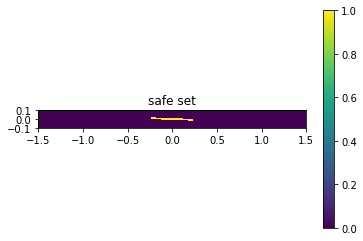

In [18]:
def plot_safe_set(lyapunov, show=True):
    """Plot the safe set for a given Lyapunov function."""
    plt.imshow(lyapunov.safe_set.reshape(safety_num_states).T,
               origin='lower',
               extent=lyapunov.discretization.limits.ravel(),
               vmin=0,
               vmax=1)
    
    if isinstance(lyapunov.dynamics, safe_learning.UncertainFunction):
        X = lyapunov.dynamics.functions[0].X
        plt.plot(X[:, 0], X[:, 1], 'rx')
    
    plt.title('safe set')
    plt.colorbar()
    if show:
        plt.show()
    
lyapunov.update_safe_set()
plot_safe_set(lyapunov)

## Safe policy update

We do dynamic programming, but enfore the decrease condition on the Lyapunov function using a Lagrange multiplier

In [19]:
with tf.name_scope('policy_optimization'):
    
    # Placeholder for states
    tf_states = tf.placeholder(safe_learning.config.dtype, [1000, 2])
    
    # Add Lyapunov uncertainty (but only if safety-relevant)
    values = rl.future_values(tf_states, lyapunov=lyapunov)
    
    policy_loss = -tf.reduce_mean(values)
    

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    adapt_policy = optimizer.minimize(policy_loss, var_list=rl.policy.parameters)
    
    
def rl_optimize_policy(num_iter):
    # Optimize value function
    session.run(rl_opt_value_function, feed_dict=rl.feed_dict)

    # select random training batches
    for i in tqdm(range(num_iter)):
        rl.feed_dict[tf_states] = lyapunov.discretization.sample_continuous(1000)

        session.run(adapt_policy, feed_dict=rl.feed_dict)

# Exploration

We explore close to the current policy by sampling the most uncertain state that does not leave the current level set

In [20]:
action_variation = np.array([[-0.02], [0.], [0.02]], dtype=safe_learning.config.np_dtype)


with tf.name_scope('add_new_measurement'):
        action_dim = lyapunov.policy.output_dim
        tf_max_state_action = tf.placeholder(safe_learning.config.dtype,
                                             shape=[1, safety_disc.ndim + action_dim])
        tf_measurement = true_dynamics(tf_max_state_action)
        
def update_gp():
    """Update the GP model based on an actively selected data point."""
    # Get a new sample location
    max_state_action, _ = safe_learning.get_safe_sample(lyapunov,
                                                        action_variation,
                                                        action_limits,
                                                        num_samples=1000)

    # Obtain a measurement of the true dynamics
    lyapunov.feed_dict[tf_max_state_action] = max_state_action
    measurement = tf_measurement.eval(feed_dict=lyapunov.feed_dict)

    # Add the measurement to our GP dynamics
    lyapunov.dynamics.add_data_point(max_state_action, measurement)
    

In [21]:
# Get a new sample location
print(lyapunov)
max_state_action, _ = safe_learning.get_safe_sample(lyapunov,
                                                        action_variation,
                                                        action_limits,
                                                        num_samples=1000)

# Run the optimization

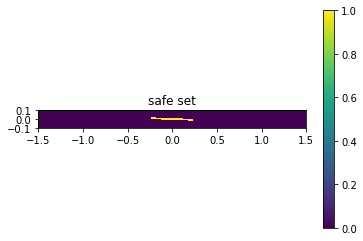

2.0314482213341103

In [22]:
# lyapunov.update_safe_set()
rl_optimize_policy(num_iter=200)

lyapunov.update_safe_set()
plot_safe_set(lyapunov)
lyapunov.feed_dict[lyapunov.c_max]

iteration 0 with c_max: 4.359407777847203


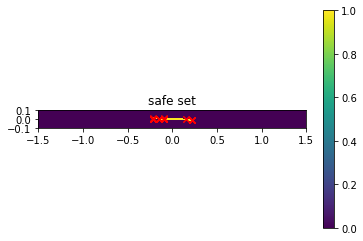

iteration 1 with c_max: 4.255593019318146


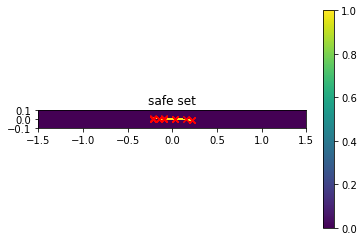

iteration 2 with c_max: 4.231486491728628


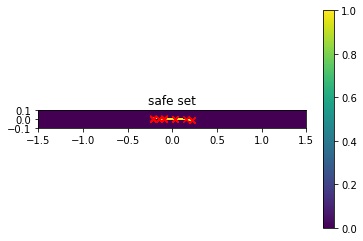

iteration 3 with c_max: 4.19030292618857


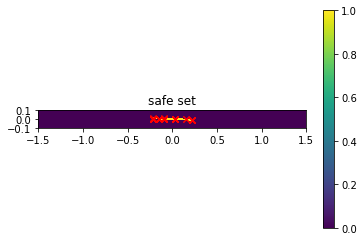

iteration 4 with c_max: 4.1770622523716066


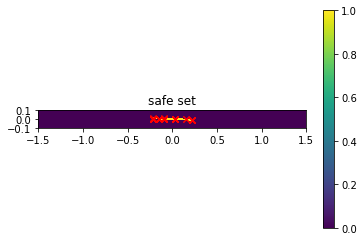

In [30]:
for i in range(5):
    print('iteration {} with c_max: {}'.format(i, lyapunov.feed_dict[lyapunov.c_max]))
    for i in tqdm(range(10)):
        update_gp()
            
    rl_optimize_policy(num_iter=100)
    lyapunov.update_values()
    
    # Update safe set and plot
    lyapunov.update_safe_set()
    plot_safe_set(lyapunov)    

# Plot trajectories and analyse improvement

In [24]:
x0 = np.array([[1., -.5]])

states_new, actions_new = safe_learning.utilities.compute_trajectory(true_dynamics, rl.policy, x0, 100)
states_old, actions_old = safe_learning.utilities.compute_trajectory(true_dynamics, init_policy, x0, 100)

t = np.arange(len(states_new)) * 1

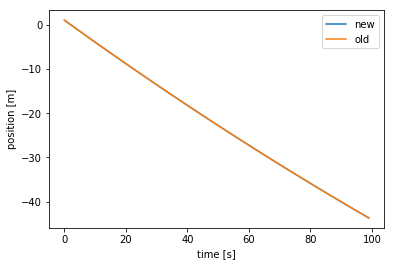

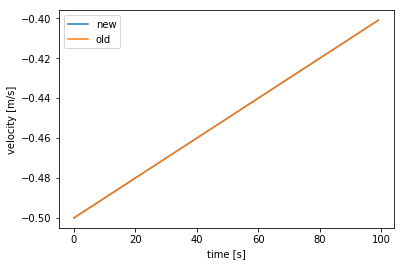

In [25]:
plt.plot(t, states_new[:, 0], label='new')
plt.plot(t, states_old[:, 0], label='old')
plt.xlabel('time [s]')
plt.ylabel('position [m]')
plt.legend()
plt.show()

plt.plot(t, states_new[:, 1], label='new')
plt.plot(t, states_old[:, 1], label='old')
plt.xlabel('time [s]')
plt.ylabel('velocity [m/s]')
plt.legend()
plt.show()

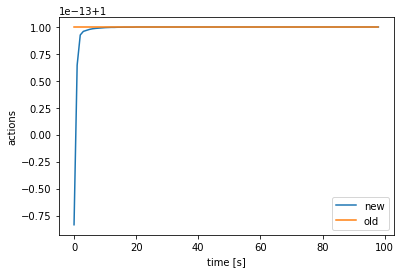

In [26]:
plt.plot(t[:-1], actions_new, label='new')
plt.plot(t[:-1], actions_old, label='old')
plt.xlabel('time [s]')
plt.ylabel('actions')
plt.legend()

In [27]:
print('reward old:', tf.reduce_sum(rl.reward_function(states_old[:-1], actions_old)).eval(feed_dict=rl.feed_dict))
print('reward new:', tf.reduce_sum(rl.reward_function(states_new[:-1], actions_new)).eval(feed_dict=rl.feed_dict))

reward old: -64203.23906699998
reward new: -64203.23906700004


In [28]:
len(states_new)

100